In [18]:
import numpy as np
import torch
import cv2
import sys

from vq_vae.auto_encoder import *

# load pretrained VQ-VAE to serve as a feature extractor
# Since VQ-VAE can binarize an image into features and does not
# lose too much information.
# now we're going to train VQ-VAE on FashionMNIST, CIFAR10, MINI-IMAGENET
# to verify our ideas of generalization.

# check pretrained VA-VQE on MNIST
net_mnist = VQ_CVAE(64, 10, num_channels=1)
net_mnist.load_state_dict(torch.load('results/2022-12-10_17-20-26/checkpoints/model_99.pth'))

<All keys matched successfully>

In [19]:
import torchvision as tv

data_mnist = tv.datasets.MNIST('../data/mnist/', train=False)
im_digits = [list() for _ in range(10)]
for _im, _digit in data_mnist:
    im_digits[_digit].append(np.array(_im))
im_digits = [np.stack(im_digits[i]) for i in range(len(im_digits))]
for i in range(len(im_digits)):
    print(im_digits[i].shape)

(980, 28, 28)
(1135, 28, 28)
(1032, 28, 28)
(1010, 28, 28)
(982, 28, 28)
(892, 28, 28)
(958, 28, 28)
(1028, 28, 28)
(974, 28, 28)
(1009, 28, 28)


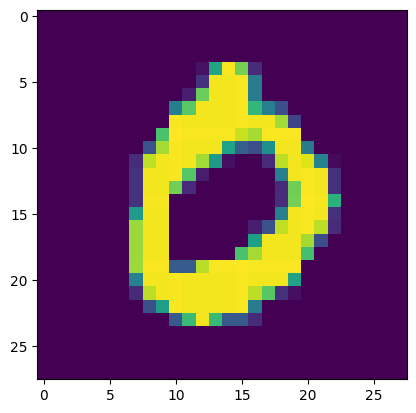

In [20]:
import matplotlib.pyplot as plt

plt.imshow(im_digits[0][0])

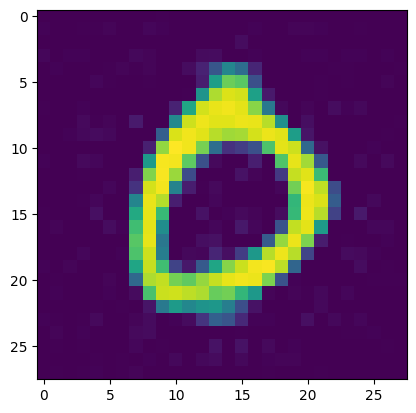

In [29]:
x =  torch.from_numpy(np.float32(im_digits[0][0].reshape([1,1,28,28]))/255.0)
x_r, z_e, emb, argmin = net_mnist(x)
im_r = np.uint8(np.clip(x_r.detach().numpy()[0][0], 0, 1)*255)
plt.imshow(im_r)

In [30]:
print(z_e.shape)
print(emb.shape)
print(argmin)
print(z_e[0,0])
print(emb[0,0])

torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 7, 7])
tensor([[[2, 2, 6, 6, 2, 2, 2],
         [2, 2, 7, 8, 0, 2, 2],
         [2, 7, 1, 4, 1, 6, 2],
         [2, 3, 5, 2, 8, 4, 2],
         [2, 8, 9, 7, 8, 9, 2],
         [2, 3, 4, 5, 9, 2, 2],
         [2, 2, 6, 0, 2, 2, 2]]])
tensor([[-0.2375, -0.2363, -0.1825, -0.2623, -0.2264, -0.2407, -0.2441],
        [-0.2409, -0.2420, -0.0991,  0.2849, -0.1495, -0.2525, -0.2401],
        [-0.2424, -0.1821,  0.1478,  0.1840,  0.3204, -0.1919, -0.2445],
        [-0.2236,  0.0522,  0.2963, -0.0200, -0.0166,  0.3303, -0.2758],
        [-0.2330,  0.2843, -0.1207,  0.0810,  0.1743,  0.1394, -0.2367],
        [-0.2169,  0.0614,  0.3033,  0.3948,  0.1370, -0.2202, -0.2367],
        [-0.2384, -0.2175, -0.1245, -0.0747, -0.2510, -0.2350, -0.2399]],
       grad_fn=<SelectBackward0>)
tensor([[-0.2139, -0.2139, -0.1772, -0.1772, -0.2139, -0.2139, -0.2139],
        [-0.2139, -0.2139, -0.1212,  0.2114, -0.0394, -0.2139, -0.2139],
        [-0.2139, -0.1212,  0.

[0 1 2 3 4 5 6 7 8 9]
[ 2  2 24  2  3  2  4  3  4  3]


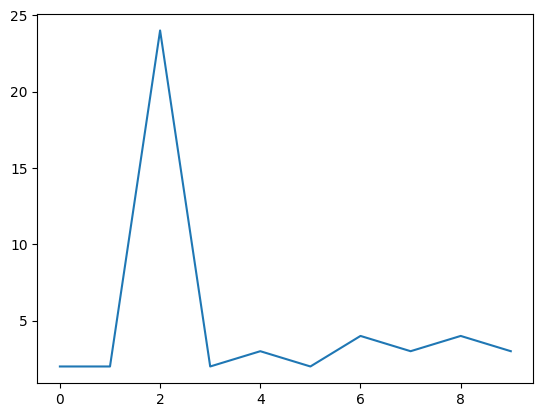

In [42]:
# check statistic features on encoded discretized vectors
code = argmin.view(-1).detach().numpy()
hist, bins = np.histogram(code, bins=np.arange(11))
bins = bins[:-1]
print(bins)
print(hist)
plt.plot(bins, hist)

tensor([[-0.2375, -0.2363, -0.1825, -0.2623, -0.2264, -0.2407, -0.2441],
        [-0.2409, -0.2420, -0.0991,  0.2849, -0.1495, -0.2525, -0.2401],
        [-0.2424, -0.1821,  0.1478,  0.1840,  0.3204, -0.1919, -0.2445],
        [-0.2236,  0.0522,  0.2963, -0.0200, -0.0166,  0.3303, -0.2758],
        [-0.2330,  0.2843, -0.1207,  0.0810,  0.1743,  0.1394, -0.2367],
        [-0.2169,  0.0614,  0.3033,  0.3948,  0.1370, -0.2202, -0.2367],
        [-0.2384, -0.2175, -0.1245, -0.0747, -0.2510, -0.2350, -0.2399]],
       grad_fn=<SelectBackward0>)
tensor([[-0.2325, -0.2312, -0.2315, -0.2094, -0.2436, -0.2202, -0.2371],
        [-0.2320, -0.1473,  0.2367,  0.1697,  0.3104, -0.0934, -0.2345],
        [-0.2332, -0.2649,  0.3397, -0.2750,  0.0133,  0.2885, -0.2508],
        [-0.2061,  0.0723,  0.0698, -0.2364, -0.0731,  0.2564, -0.2986],
        [-0.2322,  0.3373, -0.0782, -0.2160, -0.1729,  0.2331, -0.2156],
        [-0.2101,  0.1933,  0.2195,  0.2872,  0.2629, -0.1648, -0.2280],
        [-0.2343

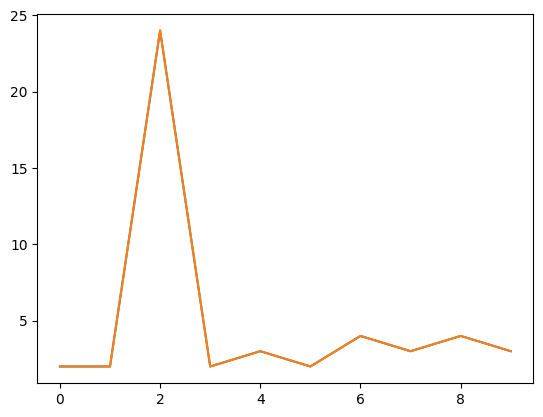

In [51]:
# count on all images of the same digit
size = 2
nclass = 10
digit_id = 0
bins = np.arange(nclass)
fig = plt.figure()
for i in range(size):
    x =  torch.from_numpy(np.float32(im_digits[digit_id][i].reshape([1,1,28,28]))/255.0)
    x_r, z_e, emb, argmins = net_mnist(x)
    code = argmin.view(-1).detach().numpy()
    hist, _ = np.histogram(code, bins=np.arange(nclass + 1))
    print(z_e[0,0])
    plt.plot(bins, hist)
plt.show()